# Profiling - why is my code slow?
Charles Simpson - Short talk at BAS

## What is profiling?
* Profiling is testing the resources that code uses. 
* You can identify different parts of your code that take a lot of time or memory. This talk will focus on time.
* If you are processing a very large dataset, time can become a limiting factor of your analysis.
* If your program only takes a few minutes, that's probably ok. But what if you need to run it $10^6$ times?

The simplest way to test some code inside a jupyter notebook is with `%%time` and/or `%%timeit`.

* `%time` is 'line magic' - will time the execution of a single line of code.
* `%%time` is 'cell magic' - will time the entire cell.

In [1]:
%time print("This will be evaluated once.")
print("This part isn't timed")

This will be evaluated once.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 137 µs
This part isn't timed


In [2]:
%%time
print("This will be evaluated")
print("once")

This will be evaluated
once
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 263 µs


* `%%timeit` will time the code multiple times in order to get better statistics.

In [3]:
%%timeit -n 2 -r 3
print("This will be evaluated multiple times.")

This will be evaluated multiple times.
This will be evaluated multiple times.
This will be evaluated multiple times.
This will be evaluated multiple times.
This will be evaluated multiple times.
This will be evaluated multiple times.
47.9 µs ± 24.4 µs per loop (mean ± std. dev. of 3 runs, 2 loops each)


* Much more detailed information can be got with a package called *line_profiler*, which will be the focus of the rest of this talk.

In [4]:
# Load the line profiler
%load_ext line_profiler

## Example 1 - How to use the profiler
In this example, I just want to show how to use the profiler, so the code is very simple.
The function `hello_world_loop` just prints a message repeatedly.

In [5]:
from time import sleep

def hello_world_loop(n_loops=5, message='hello_world'):
    """ This program just prints some numbers.
        It is made slow by the 'sleep' function.
    """

    for i in range(0, n_loops):
        print(i, message)
        
        # wait 0.1s before continuing
        sleep(0.1)

We can now run the function as `hello_world_loop()`. But how do we run it through the profiler?

The command `%lprun` invokes the profiler. `-T` tells it where to save the results. `-f` tells it what function to profile, and the final argument is the expression to be run.

In [6]:
%lprun -T lprof01.txt -f hello_world_loop hello_world_loop()

0 hello_world
1 hello_world
2 hello_world
3 hello_world
4 hello_world

*** Profile printout saved to text file 'lprof01.txt'. 


The results pop up in the notebook, but we can also load them from the file we specified by `-T`.

In [7]:
print(open('lprof01.txt', 'r').read())

Timer unit: 1e-06 s

Total time: 0.504115 s
File: <ipython-input-5-140a62bb0edb>
Function: hello_world_loop at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def hello_world_loop(n_loops=5, message='hello_world'):
     4                                               """ This program just prints some numbers.
     5                                                   It is made slow by the 'sleep' function.
     6                                               """
     7                                           
     8         6         26.0      4.3      0.0      for i in range(0, n_loops):
     9         5        831.0    166.2      0.2          print(i, message)
    10                                                   
    11                                                   # wait 0.1s before continuing
    12         5     503258.0 100651.6     99.8          sleep(0.1)


At the top, we can see the total time the the function took to run.
Then we can see a table, which shows a line-by-line breakdown of how long the code took to execute.

* 'Hits' is how many times that line was run.
* 'Time' is the total time taken by that line - in the units specified at the top.
* 'Per Hit' is the amount of time per hit - i.e. each time that line was run.
* '% Time' is the percentage of the total time the line took.

We can see that, as expected, the majority of the time is taken up by the `sleep(0.1)` command. Most of the time is will not be as obvious as this what is making code slow.

## Example 2 - a more realistic example
In this example, we will numerically integrate a polynomial. 
We will do it three different ways, and see which is best.

First, let's make a polynomial. Don't worry about these cells too much for now.

In [8]:
from numpy.polynomial import polynomial as poly
from numpy import linspace
coefficients = [0, # + 
                0.2, # * x +
                -1, # * x**2
                0.9 # * x**3
               ]
lims = (0,1)  # the integration limits

def f(x):
    """The function we will integrate"""
    return poly.polyval(x, coefficients)

true_integral_lims = poly.polyval(
    lims,
    poly.polyint(coefficients))
true_integral = true_integral_lims[1] - true_integral_lims[0]
print("true_integral:", true_integral)

true_integral: -0.008333333333333304


Let's plot the function.

Text(0, 0.5, 'f(x)')

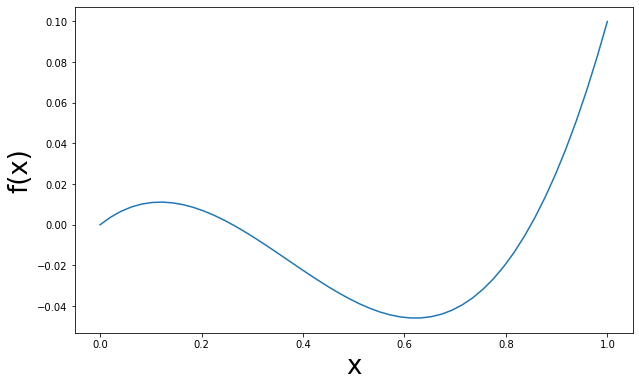

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
x = linspace(*lims)
plt.plot(x, f(x))
plt.xlabel('x', fontsize=26)
plt.ylabel('f(x)', fontsize=26)

### Example 2a - trapezium rule with explicit loops
Firstly, let's try the trapezium rule. This code uses explicit loops to evaluate all the necessary points.

In [10]:
def trapezium_a(func, lims, n_points):
    """Integration using the trapezium rule.

    The algorithm is implemented from scratch, and vectorization is not used.
    It is a little badly written on purpose!
    """
    # trapezium width
    h = (lims[1] - lims[0]) / (n_points - 1)
    
    # loop over points and evaluate y = f(x)
    x_points = [ i*h + lims[0] for i in range(n_points)]
    y_points = [ func(x) for x in x_points ]

    running_total = 0
 
    # loop over points, to sum y_1,...,y_n-1
    for i in range(1, n_points-1):
        running_total += y_points[i]

    # calculate the integral
    integral = 0.5 * h \
        * ((y_points[0] + y_points[-1]) + running_total * 2)

    return integral

Let's run the integration with 100,000 points.

In [11]:
n_points = 100000

In [12]:
print("trapezium rule answer:", "\t", trapezium_a(f, lims, n_points))
print("true answer:", "\t\t", true_integral)

trapezium rule answer: 	 -0.008333333327499888
true answer: 		 -0.008333333333333304


We can test how long this takes using `%timeit`.

In [13]:
%timeit trapezium_a(f, lims, n_points)

326 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In order to get a line-by-line breakdown, we can use `%lprun`

In [14]:
%lprun -T lprof_trapezium_a.txt -f trapezium_a trapezium_a(f, lims, n_points)
print(open("lprof_trapezium_a.txt", 'r').read())


*** Profile printout saved to text file 'lprof_trapezium_a.txt'. 
Timer unit: 1e-06 s

Total time: 0.773303 s
File: <ipython-input-10-71ee363b9b58>
Function: trapezium_a at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def trapezium_a(func, lims, n_points):
     2                                               """Integration using the trapezium rule.
     3                                           
     4                                               The algorithm is implemented from scratch, and vectorization is not used.
     5                                               It is a little badly written on purpose!
     6                                               """
     7                                               # trapezium width
     8         1          2.0      2.0      0.0      h = (lims[1] - lims[0]) / (n_points - 1)
     9                                               
    10                    

Most of the time is spent on line 18. `func(x)` is evaluated separately 100,000 times.

### Example 2b - trapezium rule with vectorization
In this case, we use the `numpy` library to vectorize the operations as much as possible.
This means that the loops are occurring in the very fast compiled code of the `numpy` library!

This allows us to treat an 'array' of points as a single object, and makes the code faster in most cases.

In [15]:
import numpy as np

def trapezium_b(func, lims, n_points):
    """Integration using the trapezium rule.

    The algorithm is implemented from scratch, but vectorization is used.
    """
    h = (lims[1] - lims[0]) / (n_points - 1)
    x_points = np.linspace(lims[0], lims[1], n_points)
    y_points = func(x_points)

    running_total = np.sum(y_points[1:-1])

    integral = 0.5 * h \
        * ((y_points[0] + y_points[-1]) + running_total * 2)
    return integral

In [16]:
print("trapezium rule answer:", "\t", trapezium_b(f, lims, n_points))
print("true answer:", "\t\t", true_integral)

trapezium rule answer: 	 -0.008333333327499876
true answer: 		 -0.008333333333333304


In [17]:
%timeit trapezium_b(f, lims, n_points)

446 µs ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This thousands of times faster than **trapezium_a**!

In [18]:
%lprun -T lprof_trapezium_b.txt -f trapezium_b trapezium_b(f, lims, n_points)
print(open("lprof_trapezium_b.txt", 'r').read())


*** Profile printout saved to text file 'lprof_trapezium_b.txt'. 
Timer unit: 1e-06 s

Total time: 0.001551 s
File: <ipython-input-15-740f983b849b>
Function: trapezium_b at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def trapezium_b(func, lims, n_points):
     4                                               """Integration using the trapezium rule.
     5                                           
     6                                               The algorithm is implemented from scratch, but vectorization is used.
     7                                               """
     8         1          2.0      2.0      0.1      h = (lims[1] - lims[0]) / (n_points - 1)
     9         1        885.0    885.0     57.1      x_points = np.linspace(lims[0], lims[1], n_points)
    10         1        585.0    585.0     37.7      y_points = func(x_points)
    11                                           
    12         1

Although `func(x)` still has to be evaluated the same number of times, the loop occurs in the fast, compiled code.

### Example 2c - using an external library
One of the great things about *python*, is that for any simple task, someone has already written the code for you!
It's better to use an implementation in a standard library if possible.

In this case, we can use the `scipy.integrate` module.

In [19]:
import scipy.integrate as integrate

In [20]:
print("quad integral answer:", "\t", integrate.quad(f, *lims))
print("true answer:", "\t\t", true_integral)

quad integral answer: 	 (-0.008333333333333316, 2.8357411135757424e-16)
true answer: 		 -0.008333333333333304


You will notice that the result is more accurate than the trapezium rule, and gives an uncertainty!

In [21]:
%timeit integrate.quad(f, *lims)

68.2 µs ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


This is a bit faster than the vectorized **trapezium_b**, and thousands of times faster than **trapezium_a**.

I won't show the results of `%lprun` in this case, as they are very long!

In [22]:
%lprun -T lprof_quad.txt -f integrate.quad integrate.quad(f, *lims)
# print(open("lprof_quad.txt", 'r').read())


*** Profile printout saved to text file 'lprof_quad.txt'. 


## Summary

1. Profiling is testing the resources your code uses - in this case *time*.

2. **How to profile**
    * `%%time` and `%%timeit` test the speed of a small amount of code in a *jupyter notebook*.
    * `%lprun` to get a line-by-line breakdown of a python function. (line_profiler)
    
3. **How to write faster python**
    * Use pre-written code in standard libraries ( e.g. *scipy.integrate* ) as much as possible. This will save you time writing code, and will already be fast.
    * *Vectorization* with *numpy* can make calculating arrays faster.

### Also note that...
* In order to apply this to your own project, you will first need to install *line_profiler*.
You can do this in the terminal using

`pip install line_profiler` 

or 

`conda install line_profiler` 

depending on what package manager you are using.
* You can also run *line_profiler* from the command line - it's not just in jupyter notebooks.
* There are other profilers for python, e.g. for memory usage.
* There are profilers for other languages, not just python.
